In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
!wget 'https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip' 

In [ ]:
!unzip MURA-v1.1.zip 

In [ ]:
drive_path='/content/drive/My Drive/MURA Challenge/data/'
path='/content/drive/My Drive/MURA Challenge/data/MURA-v1.1/'
colab_path='/content/MURA-v1.1/'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from tensorflow import keras

In [ ]:
# os.listdir(path)

In [ ]:
train_imgs_path=pd.read_csv(colab_path+'train_image_paths.csv',dtype=str,header=None,names=['Img_Path'])
train_labels=pd.read_csv(colab_path+'train_labeled_studies.csv',dtype=str,names=['Img_Path','Label'],header=None)
test_imgs_path=pd.read_csv(colab_path+'valid_image_paths.csv',dtype=str,header=None,names=['Img_Path'])
test_labels=pd.read_csv(colab_path+'valid_labeled_studies.csv',dtype=str,names=['Img_Path','Label'],header=None)

In [ ]:
def keep_dir(dir):
  x=list(dir.split('/'))
  x='/'.join(x[:5])
  x=x+'/'
  return x
def keep_dir2(dir):
  x=list(dir.split('/'))
  x='/'.join(x[3:5])
  x=x+'/'
  return x

In [ ]:
keep_dir('MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png')

'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/'

In [ ]:
train_imgs_path['path_to_merge']=train_imgs_path['Img_Path'].apply(lambda x: keep_dir(x))
test_imgs_path['path_to_merge']=test_imgs_path['Img_Path'].apply(lambda x: keep_dir(x))

In [ ]:
train_data=train_imgs_path.merge(train_labels,how='inner',left_on='path_to_merge', right_on='Img_Path')
test_data=test_imgs_path.merge(test_labels,how='inner',left_on='path_to_merge', right_on='Img_Path')

In [ ]:
train_data['Body_Part']=train_data['Img_Path_x'].apply(lambda x: str(x.split('/')[2]))
test_data['Body_Part']=test_data['Img_Path_x'].apply(lambda x: str(x.split('/')[2]))
train_data['Patient/Study']=train_data['Img_Path_x'].apply(lambda x: str(x.split('/')[3:5]))
test_data['Patient/Study']=test_data['Img_Path_x'].apply(lambda x: str(x.split('/')[3:5]))
train_data['Patient/Study']=train_data['Img_Path_x'].apply(lambda x: keep_dir2(x) )
test_data['Patient/Study']=test_data['Img_Path_x'].apply(lambda x: keep_dir2(x) )
train_data.drop(columns=['path_to_merge','Img_Path_y'],inplace=True)
train_data.rename(columns={'Img_Path_x':'Img_Path'},inplace=True)
test_data.drop(columns=['path_to_merge','Img_Path_y'],inplace=True)
test_data.rename(columns={'Img_Path_x':'Img_Path'},inplace=True)

test_labels['Body_Part']=test_labels['Img_Path'].apply(lambda x: str(x.split('/')[2]))
test_labels['Patient/Study']=test_labels['Img_Path'].apply(lambda x:  keep_dir2(x))


# train_data.Img_Path=train_data.Img_Path.apply(lambda x: drive_path+x)
# test_data.Img_Path=test_data.Img_Path.apply(lambda x: drive_path+x)

### Prep Data For Training




In [ ]:
# train_data=train_data[train_data.Body_Part=='XR_ELBOW']

In [ ]:
shuffled=train_data.sample(frac=1)

In [ ]:
msk = np.random.rand(len(shuffled)) < 0.8

train = shuffled[msk]

val= shuffled[~msk]

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
#split train data to train and val
#X_train, X_val, y_train, y_val=train_test_split(train_data.Img_Path,to_categorical(train_data.Label), test_size=0.2, random_state=42)

In [ ]:
# train_generator = DataGenerator(train_data.Img_Path,train_data.Label)

### Define Evaluation metrics & Helper Functions


In [ ]:
import keras.backend as K
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


# def accuracy(y_true, y_pred):
#     return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

In [ ]:
# for visualizing the training progress of our models
%matplotlib inline
import matplotlib.pyplot as plt
def viz_history(hs_dict,metric):
  plt.style.use('dark_background')
  plt.rcParams['figure.figsize'] = [15, 8]
  plt.rcParams['font.size'] = 16
  plt.clf()
  for model in hs_dict.keys():
    plt.plot(hs_dict[model].history[metric],label='{0:s} train {1:s}'.format(model, metric))
    plt.plot(hs_dict[model].history['val_{0:s}'.format(metric)],label='{0:s} validation {1:s}'.format(model, metric))
    plt.ylabel(metric) 
    plt.xlabel('epoch')
    plt.legend()
  plt.show()

### Create DenseNet 169 model

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications.densenet import DenseNet169
from keras.callbacks import *

In [ ]:
def buildDenseNet(height, width, channels, n_classes):
  in_shape=(height, width, channels)
  
  dense_169_model = DenseNet169(weights='imagenet', 
                           include_top=False, 
                           input_shape=in_shape,
                           pooling='avg'
                           )
  
  x = dense_169_model.output 
  #x= Flatten()(x)
  output = Dense(n_classes, activation='softmax', name='predictions')(x)
  model = Model(inputs=dense_169_model.input, output=output)

  for layer in dense_169_model.layers:
          layer.trainable = True

  model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=['acc',f1])



  return model

In [ ]:
DenseNetModel=buildDenseNet(height=224, width=224, channels = 3, n_classes = 2);

In [ ]:
callback_list = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,cooldown=2, verbose=1, mode='auto'),
             ModelCheckpoint(filepath='best_model_unfreezed.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
#model parameters for training
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

In [ ]:
#fit DensnetModel
# dense_hist=DenseNetModel.fit(x=train_dict['images'],
#                              y=train_dict['labels'],
#                              validation_data=(valid_dict['images'],valid_dict['labels']),
#                              batch_size=32,
#                              epochs=7,
#                              callbacks=callbacks,
#                              verbose=1
#                     )

dense_hist=DenseNetModel.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=val_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=callback_list,
    verbose=1
                    )

Epoch 1/20
919/919 [==============================] - 1058s 1s/step - loss: 0.5269 - acc: 0.7492 - f1: 0.7491 - val_loss: 0.4491 - val_acc: 0.7855 - val_f1: 0.7855
Epoch 2/20
919/919 [==============================] - 993s 1s/step - loss: 0.4565 - acc: 0.7952 - f1: 0.7952 - val_loss: 0.5083 - val_acc: 0.7854 - val_f1: 0.7855
Epoch 3/20
919/919 [==============================] - 995s 1s/step - loss: 0.4291 - acc: 0.8123 - f1: 0.8123 - val_loss: 0.4660 - val_acc: 0.7998 - val_f1: 0.7999

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/20
919/919 [==============================] - 996s 1s/step - loss: 0.3672 - acc: 0.8444 - f1: 0.8444 - val_loss: 0.5143 - val_acc: 0.8330 - val_f1: 0.8331
Epoch 5/20
919/919 [==============================] - 994s 1s/step - loss: 0.3402 - acc: 0.8569 - f1: 0.8569 - val_loss: 0.8929 - val_acc: 0.8334 - val_f1: 0.8335
Epoch 6/20
919/919 [==============================] - 996s 1s/step - loss: 0.3199 - acc: 0.8654 - f1: 0

KeyboardInterrupt: ignored

In [ ]:
# !cp '/content/best_model_freezed.h5' '/content/drive/My Drive/Deep Learning/Saved Models Project 2'

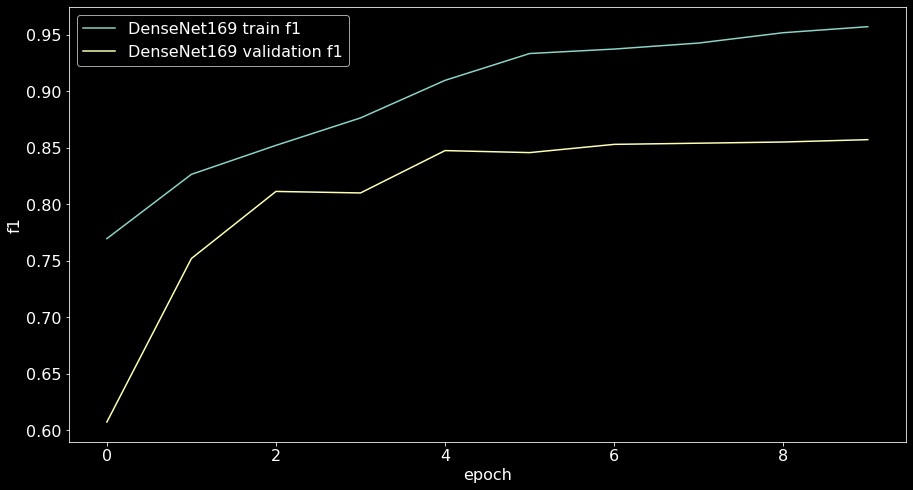

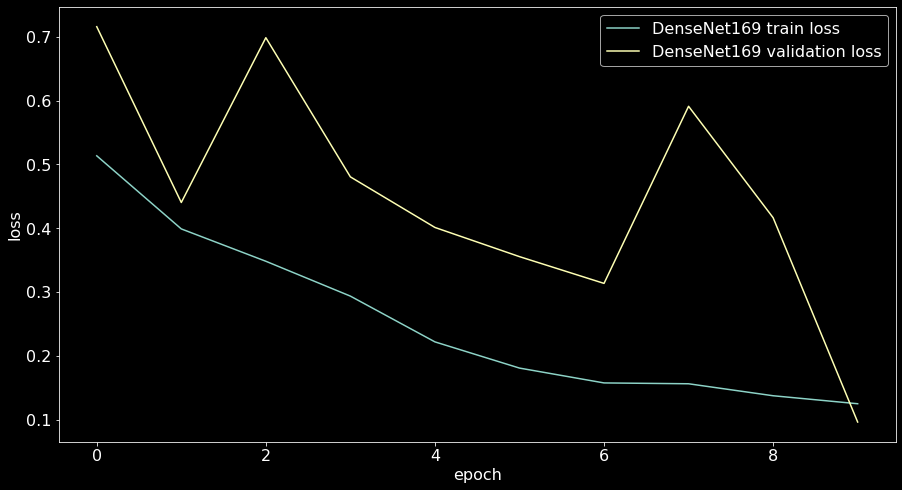

In [ ]:
viz_history(hs_dict={'DenseNet169':dense_hist},metric='f1')
viz_history(hs_dict={'DenseNet169':dense_hist},metric='loss')

#### Evaluation on test set/ No test data augmentation


In [ ]:
# test_elbow=test_data[test_data.Body_Part=='XR_ELBOW']
# test_labels_elbow=test_labels[test_labels.Body_Part=='XR_ELBOW']

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col="Img_Path",
    y_col="Label",
    weight_col=None,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=128,
    shuffle=False,
    seed=1,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    interpolation="nearest",
    validate_filenames=False
)


Found 3197 non-validated image filenames belonging to 2 classes.


In [ ]:
preds=DenseNetModel.predict(test_generator,
                            verbose=1)

25/25 [==============================] - 36s 1s/step


In [ ]:
voting_df=pd.DataFrame(data=np.c_[test_data['Patient/Study'].values,preds],
                       columns=['Patient/Study','Class 0 prob','Class 1 prob'])
voting_df[['Class 0 prob', 'Class 1 prob']] = voting_df[['Class 0 prob', 'Class 1 prob']].apply(pd.to_numeric)   

In [ ]:
voting_df=voting_df.groupby('Patient/Study').mean().reset_index()

In [ ]:
voting_df=voting_df.merge(test_labels,how='inner',on='Patient/Study')
voting_df=voting_df.drop(columns=['Img_Path'])

In [ ]:
voting_df['Label'] = voting_df['Label'].apply(pd.to_numeric) 

In [ ]:
voting_df.dtypes

Patient/Study        object
Class 0 prob        float64
Class 1 prob        float64
Class_prediction      int64
Label                 int64
Body_Part            object
dtype: object

In [ ]:
from sklearn.metrics import *

In [ ]:
cohen_kappa_score(voting_df.Class_prediction,voting_df.Label)

0.6814618447827467

In [ ]:
f1_score(voting_df.Class_prediction,voting_df.Label)

0.806282722513089

In [ ]:
voting_df

,Patient/Study,Class 0 prob,Class 1 prob,Class_prediction,Label,Body_Part
0,patient11185/study1_positive/,0.184163,0.815837,1,1,XR_WRIST
1,patient11186/study1_positive/,0.071153,0.928847,1,1,XR_WRIST
2,patient11186/study1_positive/,0.071153,0.928847,1,1,XR_HUMERUS
3,patient11186/study1_positive/,0.071153,0.928847,1,1,XR_SHOULDER
4,patient11186/study1_positive/,0.071153,0.928847,1,1,XR_ELBOW
...,...,...,...,...,...,...
1194,patient11963/study1_negative/,0.224424,0.775576,1,0,XR_FINGER
1195,patient11964/study1_negative/,0.919738,0.080262,0,0,XR_FINGER
1196,patient11965/study1_negative/,0.999665,0.000335,0,0,XR_FINGER
1197,patient11966/study1_negative/,0.979315,0.020685,0,0,XR_FINGER


In [ ]:
print(classification_report(voting_df.Label, voting_df.Class_prediction, target_names=['negative (0)','positive (1)']))

              precision    recall  f1-score   support

negative (0)       0.80      0.95      0.87       661
positive (1)       0.92      0.72      0.81       538

    accuracy                           0.85      1199
   macro avg       0.86      0.83      0.84      1199
weighted avg       0.86      0.85      0.84      1199



#### Test time augmentation


The reason it might work is that, by averaging our predictions, on randomly modified images, we are also averaging the errors. The error can be big in a single vector, leading to a wrong answer, but when averaged,the correct answer might stand out.

Test Time Augmentation is particularly useful for test images that the model is pretty unsure. Even if those 5 images seemed very similar to the reviewer, for the model they were very different, by looking at its predictions.

To do Test Time Augmentation, we can reuse the same Data Generator used for training, and apply it to validation images.

We can then show the model 10 times (for example) the randomly modified images, get the prediction for each, and take the average:


In [ ]:
test_generator=train_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col="Img_Path",
    y_col="Label",
    weight_col=None,
    target_size=(224, 224),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=128,
    shuffle=False,
    seed=1,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    interpolation="nearest",
    validate_filenames=False
)

Found 3197 non-validated image filenames belonging to 2 classes.


In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = DenseNetModel.predict(test_generator,verbose=1)
    predictions.append(preds)

In [ ]:
pred = np.mean(predictions, axis=0)
pred.shape

(3197, 2)

In [ ]:
voting_df=pd.DataFrame(data=np.c_[test_data['Patient/Study'].values,pred],
                       columns=['Patient/Study','Class 0 prob','Class 1 prob'])
voting_df[['Class 0 prob', 'Class 1 prob']] = voting_df[['Class 0 prob', 'Class 1 prob']].apply(pd.to_numeric)   

In [ ]:
voting_df=voting_df.groupby('Patient/Study').mean().reset_index()

In [ ]:
voting_df['Class_prediction']=np.argmax(voting_df.iloc[:,1:3].values,axis=1)

In [ ]:
voting_df=voting_df.merge(test_labels,how='inner',on='Patient/Study')
voting_df=voting_df.drop(columns=['Img_Path'])
voting_df['Label'] = voting_df['Label'].apply(pd.to_numeric) 

In [ ]:
from sklearn.metrics import *

In [ ]:
cohen_kappa_score(voting_df.Class_prediction,voting_df.Label)

0.7041098274388862

In [ ]:
f1_score(voting_df.Class_prediction,voting_df.Label)

0.8257804632426989

In [ ]:
print(classification_report(voting_df.Label, voting_df.Class_prediction, target_names=['negative (0)','positive (1)']))

              precision    recall  f1-score   support

negative (0)       0.83      0.93      0.88       661
positive (1)       0.90      0.76      0.83       538

    accuracy                           0.86      1199
   macro avg       0.86      0.85      0.85      1199
weighted avg       0.86      0.86      0.85      1199



In [ ]:
def calculate_kappa_scores_per_body_part(df):
  body_part_type=df.Body_Part.unique()
  res={}
  for i in body_part_type:
    tmp=df[df.Body_Part==i]
    kappa_score=cohen_kappa_score(tmp.Class_prediction,tmp.Label)
    res[i]=kappa_score
  return res

In [ ]:
kappa_score_per_body_part=calculate_kappa_scores_per_body_part(voting_df)

In [ ]:
kappa_score_per_body_part

{'XR_ELBOW': 0.7479429051217464,
 'XR_FINGER': 0.6062210456651225,
 'XR_FOREARM': 0.7114308553157473,
 'XR_HAND': 0.6844591402928673,
 'XR_HUMERUS': 0.777789970371996,
 'XR_SHOULDER': 0.6280754073916285,
 'XR_WRIST': 0.7672257479601088}